In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import sam2
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor

print(dir(sam2))

['GlobalHydra', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'build_sam', 'initialize_config_module']


In [ ]:
sam2_checkpoint = "../../checkpoints/sam2.1_hiera_small.pt"
model_cfg = "sam2.1_hiera_s.yaml"

sam2_model = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device="cuda")

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0], pos_points[:, 1], color="green", marker="*", s=marker_size, edgecolor="white", linewidth=1.25
    )
    ax.scatter(
        neg_points[:, 0], neg_points[:, 1], color="red", marker="*", s=marker_size, edgecolor="white", linewidth=1.25
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2))

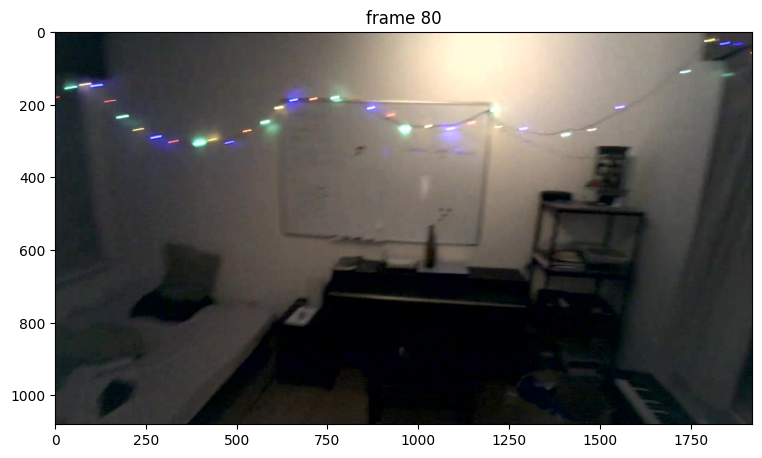

In [ ]:
video_dir = "./videos/"

frame_names = [p for p in os.listdir(video_dir) if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 80
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [ ]:
inference_state = sam2_model.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 737/737 [00:20<00:00, 35.52it/s]


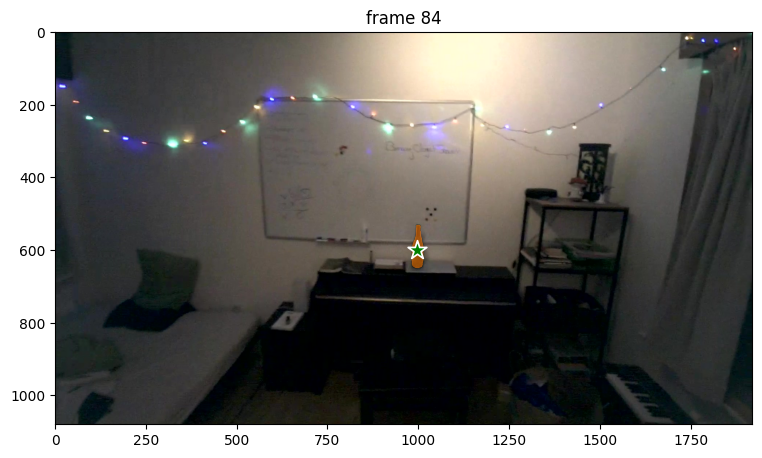

In [ ]:
ann_frame_idx = 84  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[997, 600]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = sam2_model.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in sam2_model.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy() for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video: 100%|██████████| 653/653 [00:38<00:00, 17.06it/s]


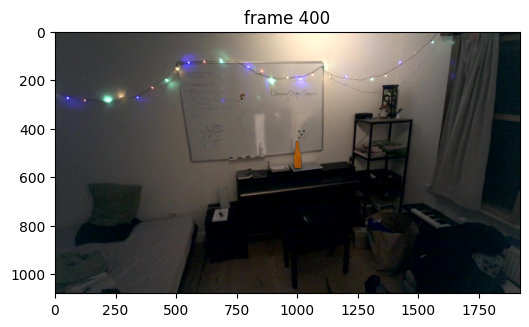

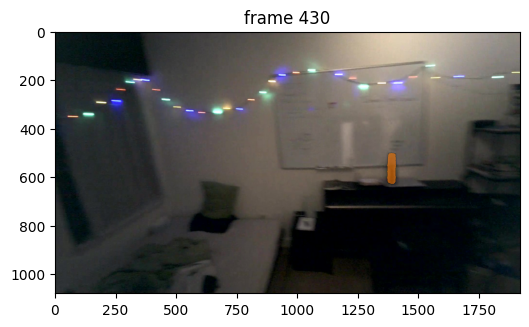

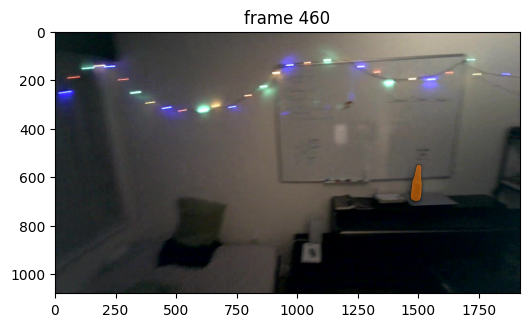

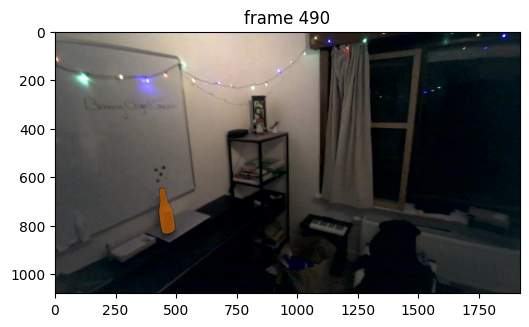

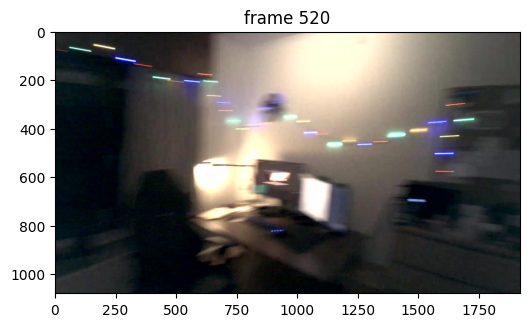

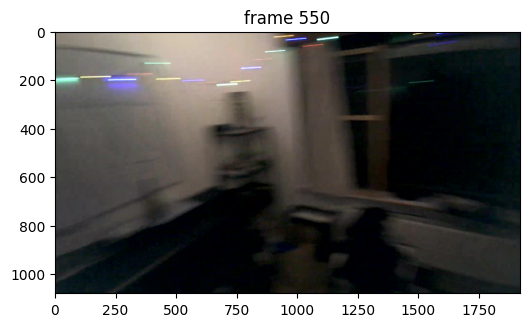

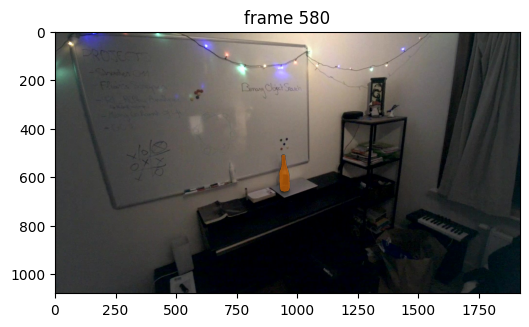

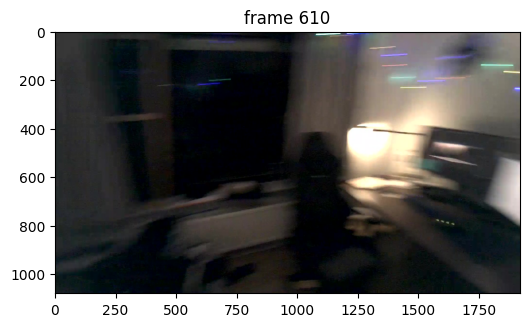

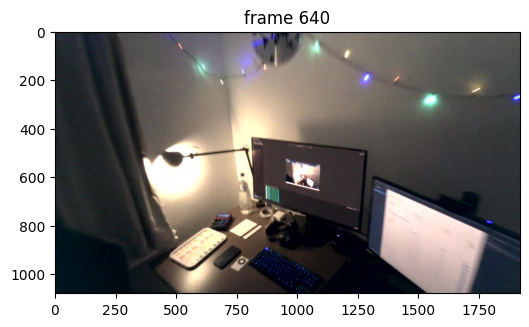

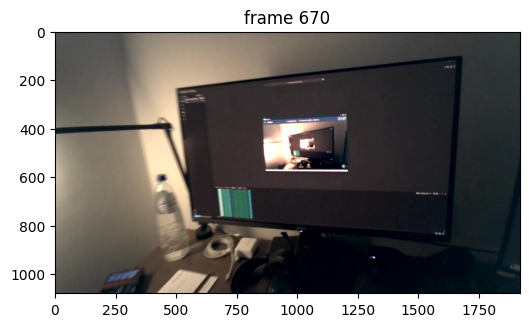

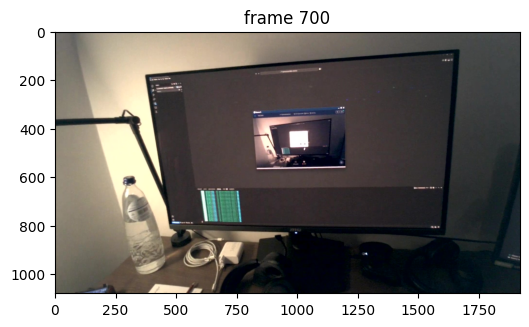

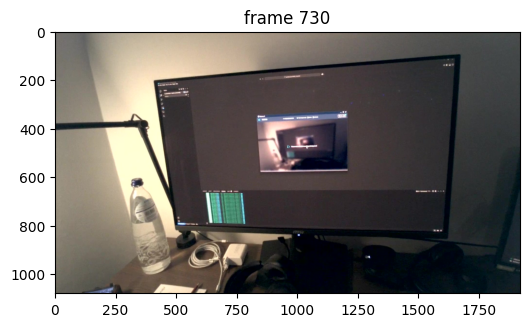

In [ ]:
# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(ann_frame_idx, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [ ]:
output_dir = "./output/"
os.makedirs(output_dir, exist_ok=True)

for out_frame_idx in range(ann_frame_idx, len(frame_names)):
    img = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    img = img.convert("RGBA")  # Convert to RGBA mode to support alpha channel

    # overlay each mask on top of the image
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        h, w = out_mask.shape[-2:]
        mask_image = out_mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

        # Convert numpy array to PIL Image
        mask_overlay = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")

        img = Image.alpha_composite(img, mask_overlay)

        img = img.convert("RGB")  # Convert back to RGB before saving
        img.save(os.path.join(output_dir, f"{out_frame_idx}.jpg"))

# ffmpeg -framerate 24.95 -pattern_type glob -i "*.jpg" -c:v libx264 -r 24.95 -pix_fmt yuv420p output.mp4